In [ ]:
import sys
import numpy as np
import torch
from torch import Tensor, ones, stack, load
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from scipy import stats
from tesladatadiff2 import TeslaDatasetDiff

sys.path.append("/content/drive/MyDrive/NeuralSolvers-heat-eqn") 
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [ ]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
normalize=1000
batch_size = 1

In [ ]:
# Create instance of the dataset
ds = TeslaDatasetDiff(device = device, normalize = normalize, ID = 30)

(2301, 10)


In [ ]:
train_loader = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
#next(iter(train_loader))

In [ ]:
model = pf.models.MLP(input_size=5,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub,
                      activation = torch.relu
                      )
model.to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

Starting epoch 0
Epoch  0 Total Loss  1.4678399177607085e-07
Starting epoch 1
Epoch  1 Total Loss  1.1533950209733727e-07
Starting epoch 2
Epoch  2 Total Loss  9.426541917415913e-08
Starting epoch 3
Epoch  3 Total Loss  7.917097436897318e-08
Starting epoch 4
Epoch  4 Total Loss  6.82810335680036e-08
Starting epoch 5
Epoch  5 Total Loss  6.029188763060726e-08
Starting epoch 6
Epoch  6 Total Loss  5.482659970468262e-08
Starting epoch 7
Epoch  7 Total Loss  5.136210597574594e-08
Starting epoch 8
Epoch  8 Total Loss  4.911091799897349e-08
Starting epoch 9
Epoch  9 Total Loss  4.729759961463742e-08
Starting epoch 10
Epoch  10 Total Loss  4.543073946668604e-08
Starting epoch 11
Epoch  11 Total Loss  4.333578325817674e-08
Starting epoch 12
Epoch  12 Total Loss  4.11124162861635e-08
Starting epoch 13
Epoch  13 Total Loss  3.89401497713493e-08
Starting epoch 14
Epoch  14 Total Loss  3.703114614950209e-08
Starting epoch 15
Epoch  15 Total Loss  3.538882461147826e-08
Starting epoch 16
Epoch  16 T

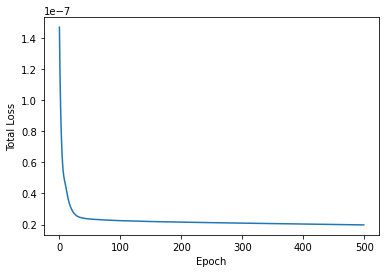

In [ ]:
x_data_plot=[]
y_data_all_plot=[]
y_data_1_plot=[]
y_data_2_plot=[]

# Set fixed random number seed
torch.manual_seed(42)

Epochs = 500
for epoch in range(Epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')
    
    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0
    total_loss1 = 0.0
    total_loss2 = 0.0

    for i, data in enumerate(train_loader,0):

        x_batch, y_batch, delta_t = data

        # Ground-truth temperature
        true_temp = x_batch[:,4]

        # Predicted temperature using model prediction and forward euler method
        pred_temp = true_temp.detach().clone().to(device)

        optimizer.zero_grad()
        prediction = model(x_batch.to(device)) 
        #print('prediction', prediction.shape)
        deltaTemp = prediction.reshape(-1)*delta_t.reshape(-1)/normalize
        temp0 = pred_temp + deltaTemp
        pred_temp[1:] = temp0[:-1]
 
        #loss1 = criterion(prediction,y_batch.to(device))
        loss = criterion(pred_temp.to(device),true_temp.to(device))
        #loss = loss1+loss2

        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()
        #total_loss1 += loss1.item()
        #total_loss2 += loss2.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0

    print("Epoch ", epoch, "Total Loss ", total_loss/(i+1))
    #print("Epoch ", epoch, "Loss 1 ", total_loss1/(i+1))
    #print("Epoch ", epoch, "Loss 2", total_loss2/(i+1))

    x_data_plot.append(epoch)
    y_data_all_plot.append(total_loss/(i+1))
    #y_data_1_plot.append(total_loss1/(i+1))
    #y_data_2_plot.append(total_loss2/(i+1))

# Make the plot of Total Loss vs epochs
plt.plot(x_data_plot,y_data_all_plot)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()

# Make the plot of the supervised loss
#plt.plot(x_data_plot,y_data_1_plot)
#plt.xlabel('Epoch')
#plt.ylabel('Loss1')
#plt.show()

# Make the plot of time stability loss
#plt.plot(x_data_plot,y_data_2_plot)
#plt.xlabel('Epoch')
#plt.ylabel('Loss2')
#plt.show()

In [ ]:
torch.save(model.state_dict(),  'model_' + str(normalize) + str(batch_size)+'.pt')

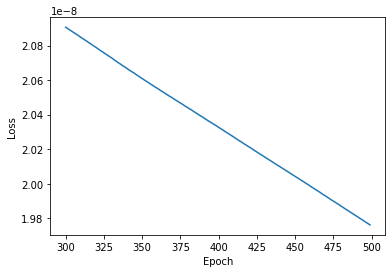

In [ ]:
# Plot of last 100 epochs
plt.plot(x_data_plot[-200:],y_data_all_plot[-200:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot of last 100 epochs
#plt.plot(x_data_plot[-200:],y_data_1_plot[-200:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss 1')
#plt.show()

# Plot of last 100 epochs
#plt.plot(x_data_plot[-200:],y_data_2_plot[-200:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss 2')
#plt.show()

In [ ]:
# Make a prediction
pred = model(ds.x.float().to(device)) 
pred = pred.detach().cpu().numpy()/normalize

# ground-truth
df_y_tensor_np = ds.y.numpy()/normalize

In [ ]:
# Some statistics on the model performance on all of dataset
mae = np.sum(np.abs(pred- df_y_tensor_np).mean(axis=None))
print('MAE:', mae)

mse = ((df_y_tensor_np - pred)**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(pred - df_y_tensor_np) / np.linalg.norm(df_y_tensor_np)
print('Relative error (%):', rel_error*100)


MAE: 0.00023729853
MSE: 1.8807324e-07
Relative error (%): 56.228482723236084


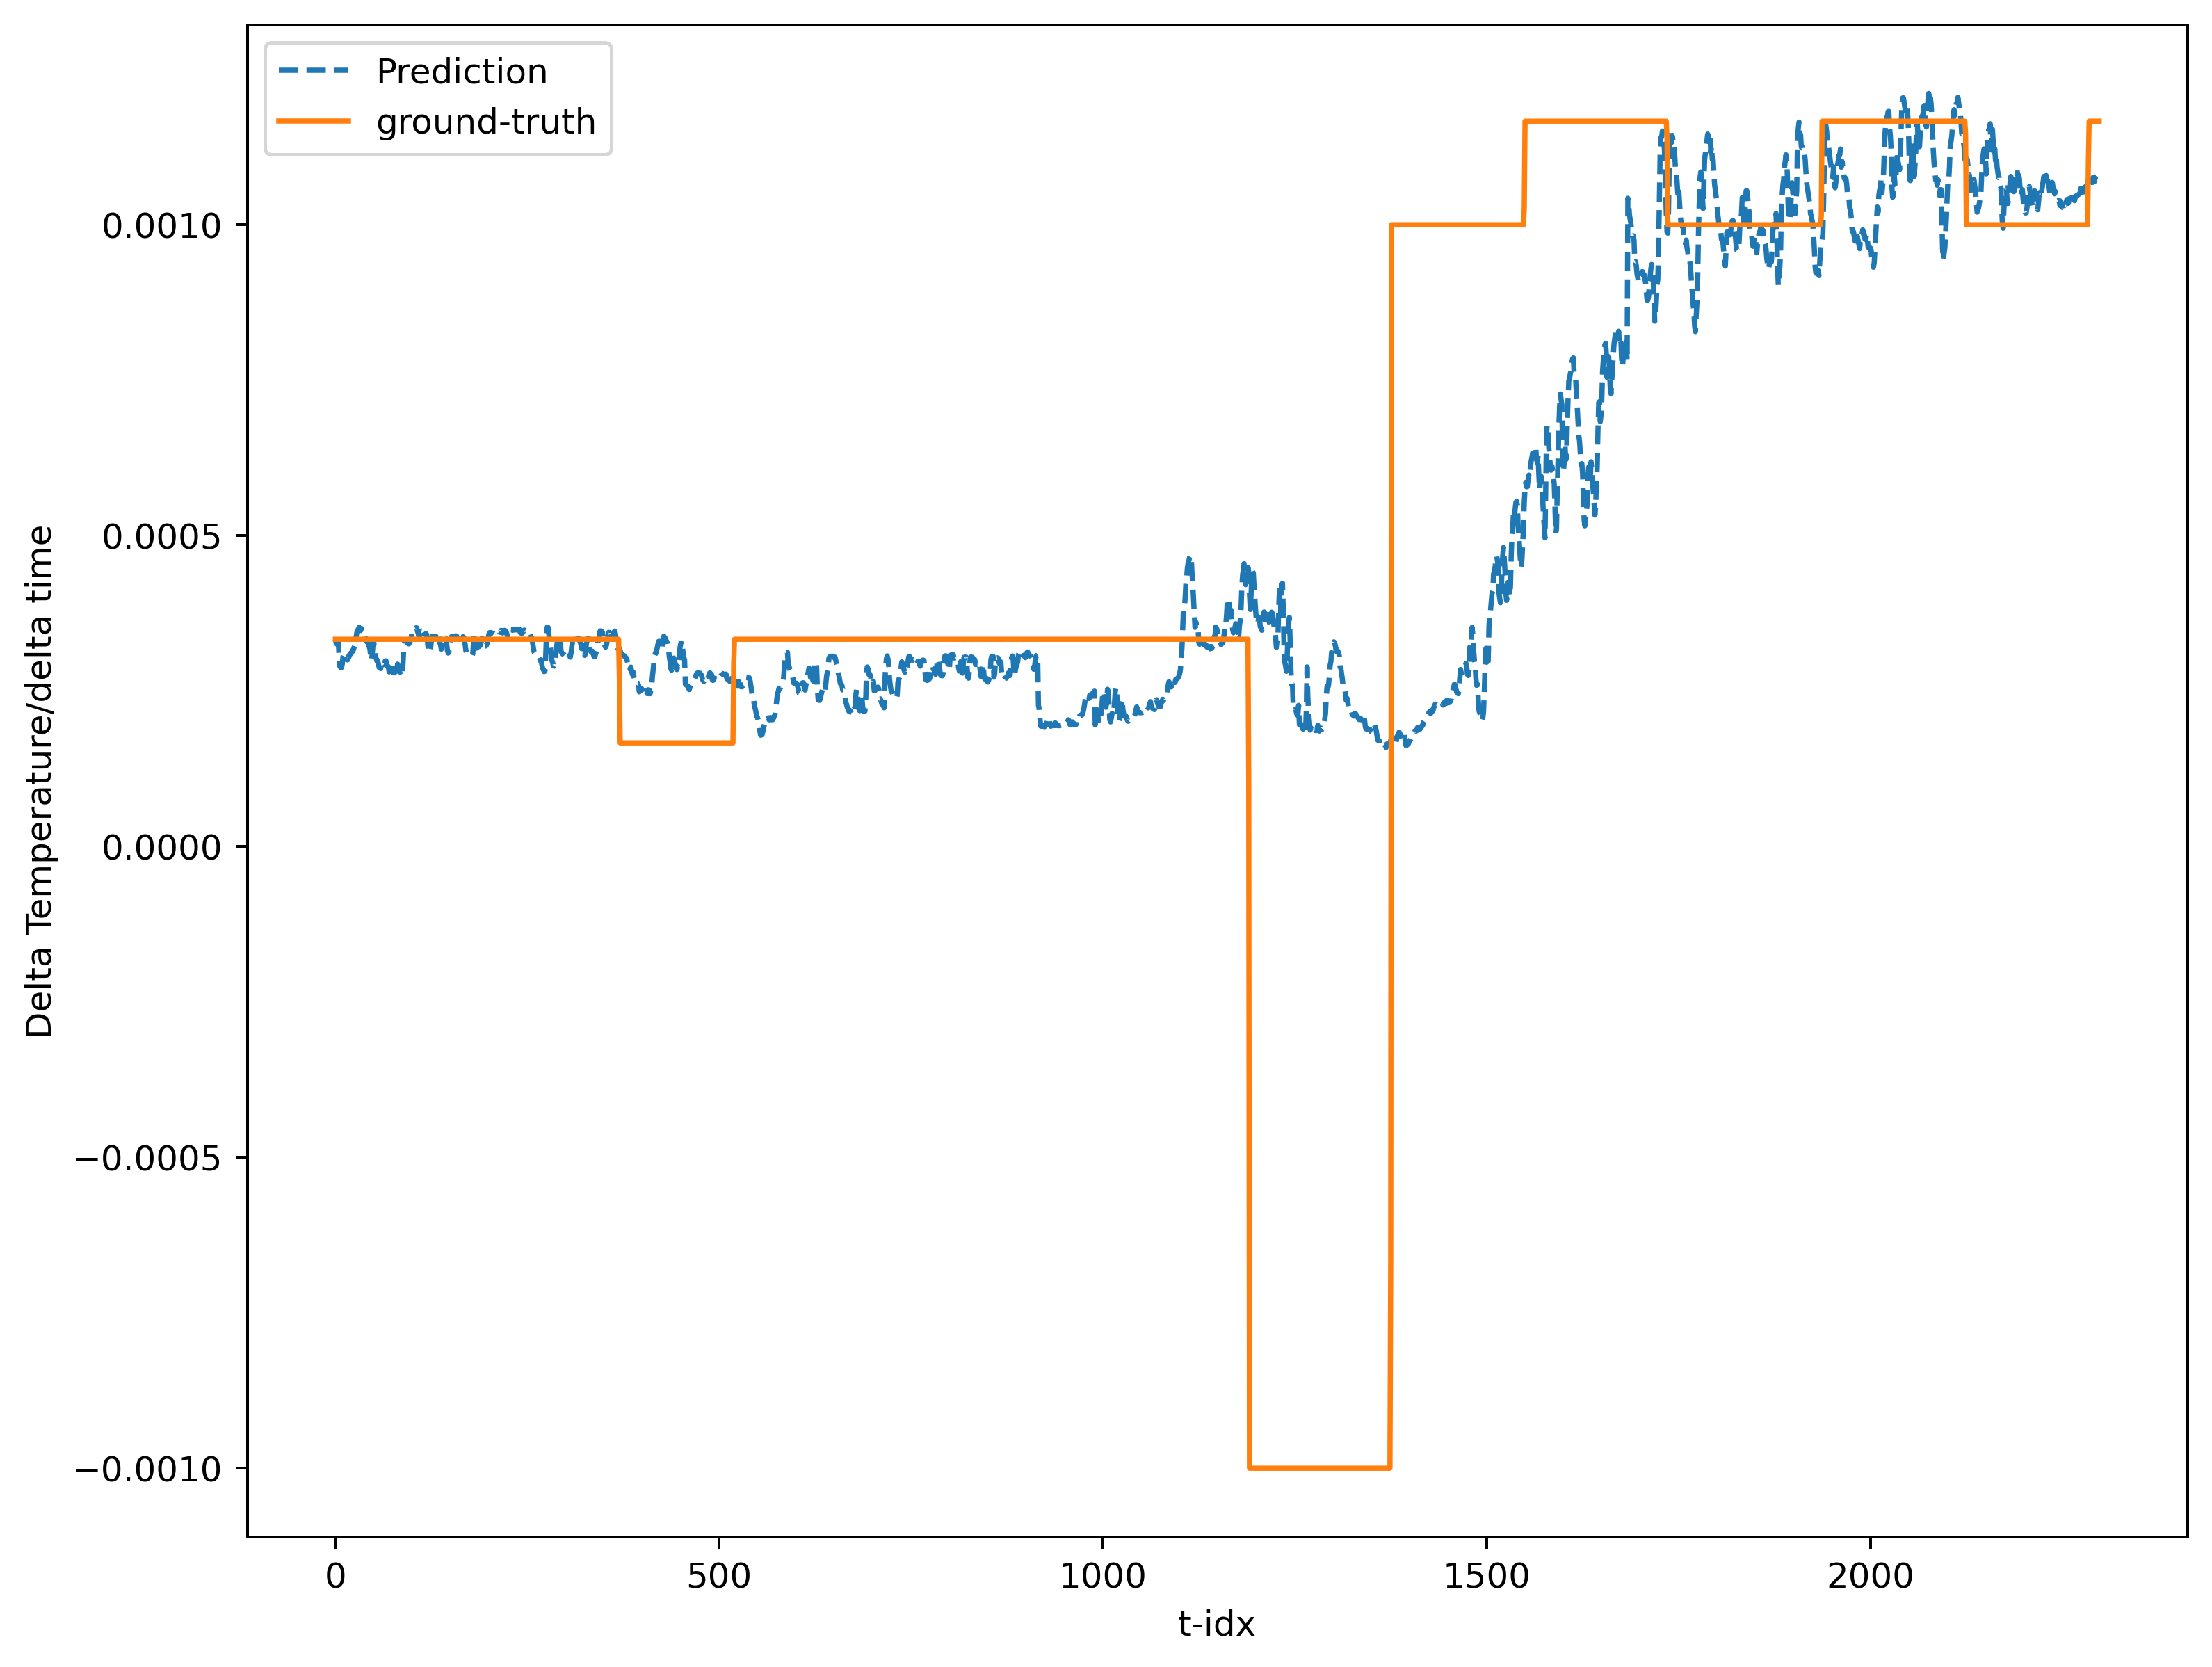

In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('t-idx')
plt.ylabel('Delta Temperature/delta time')
plt.show()



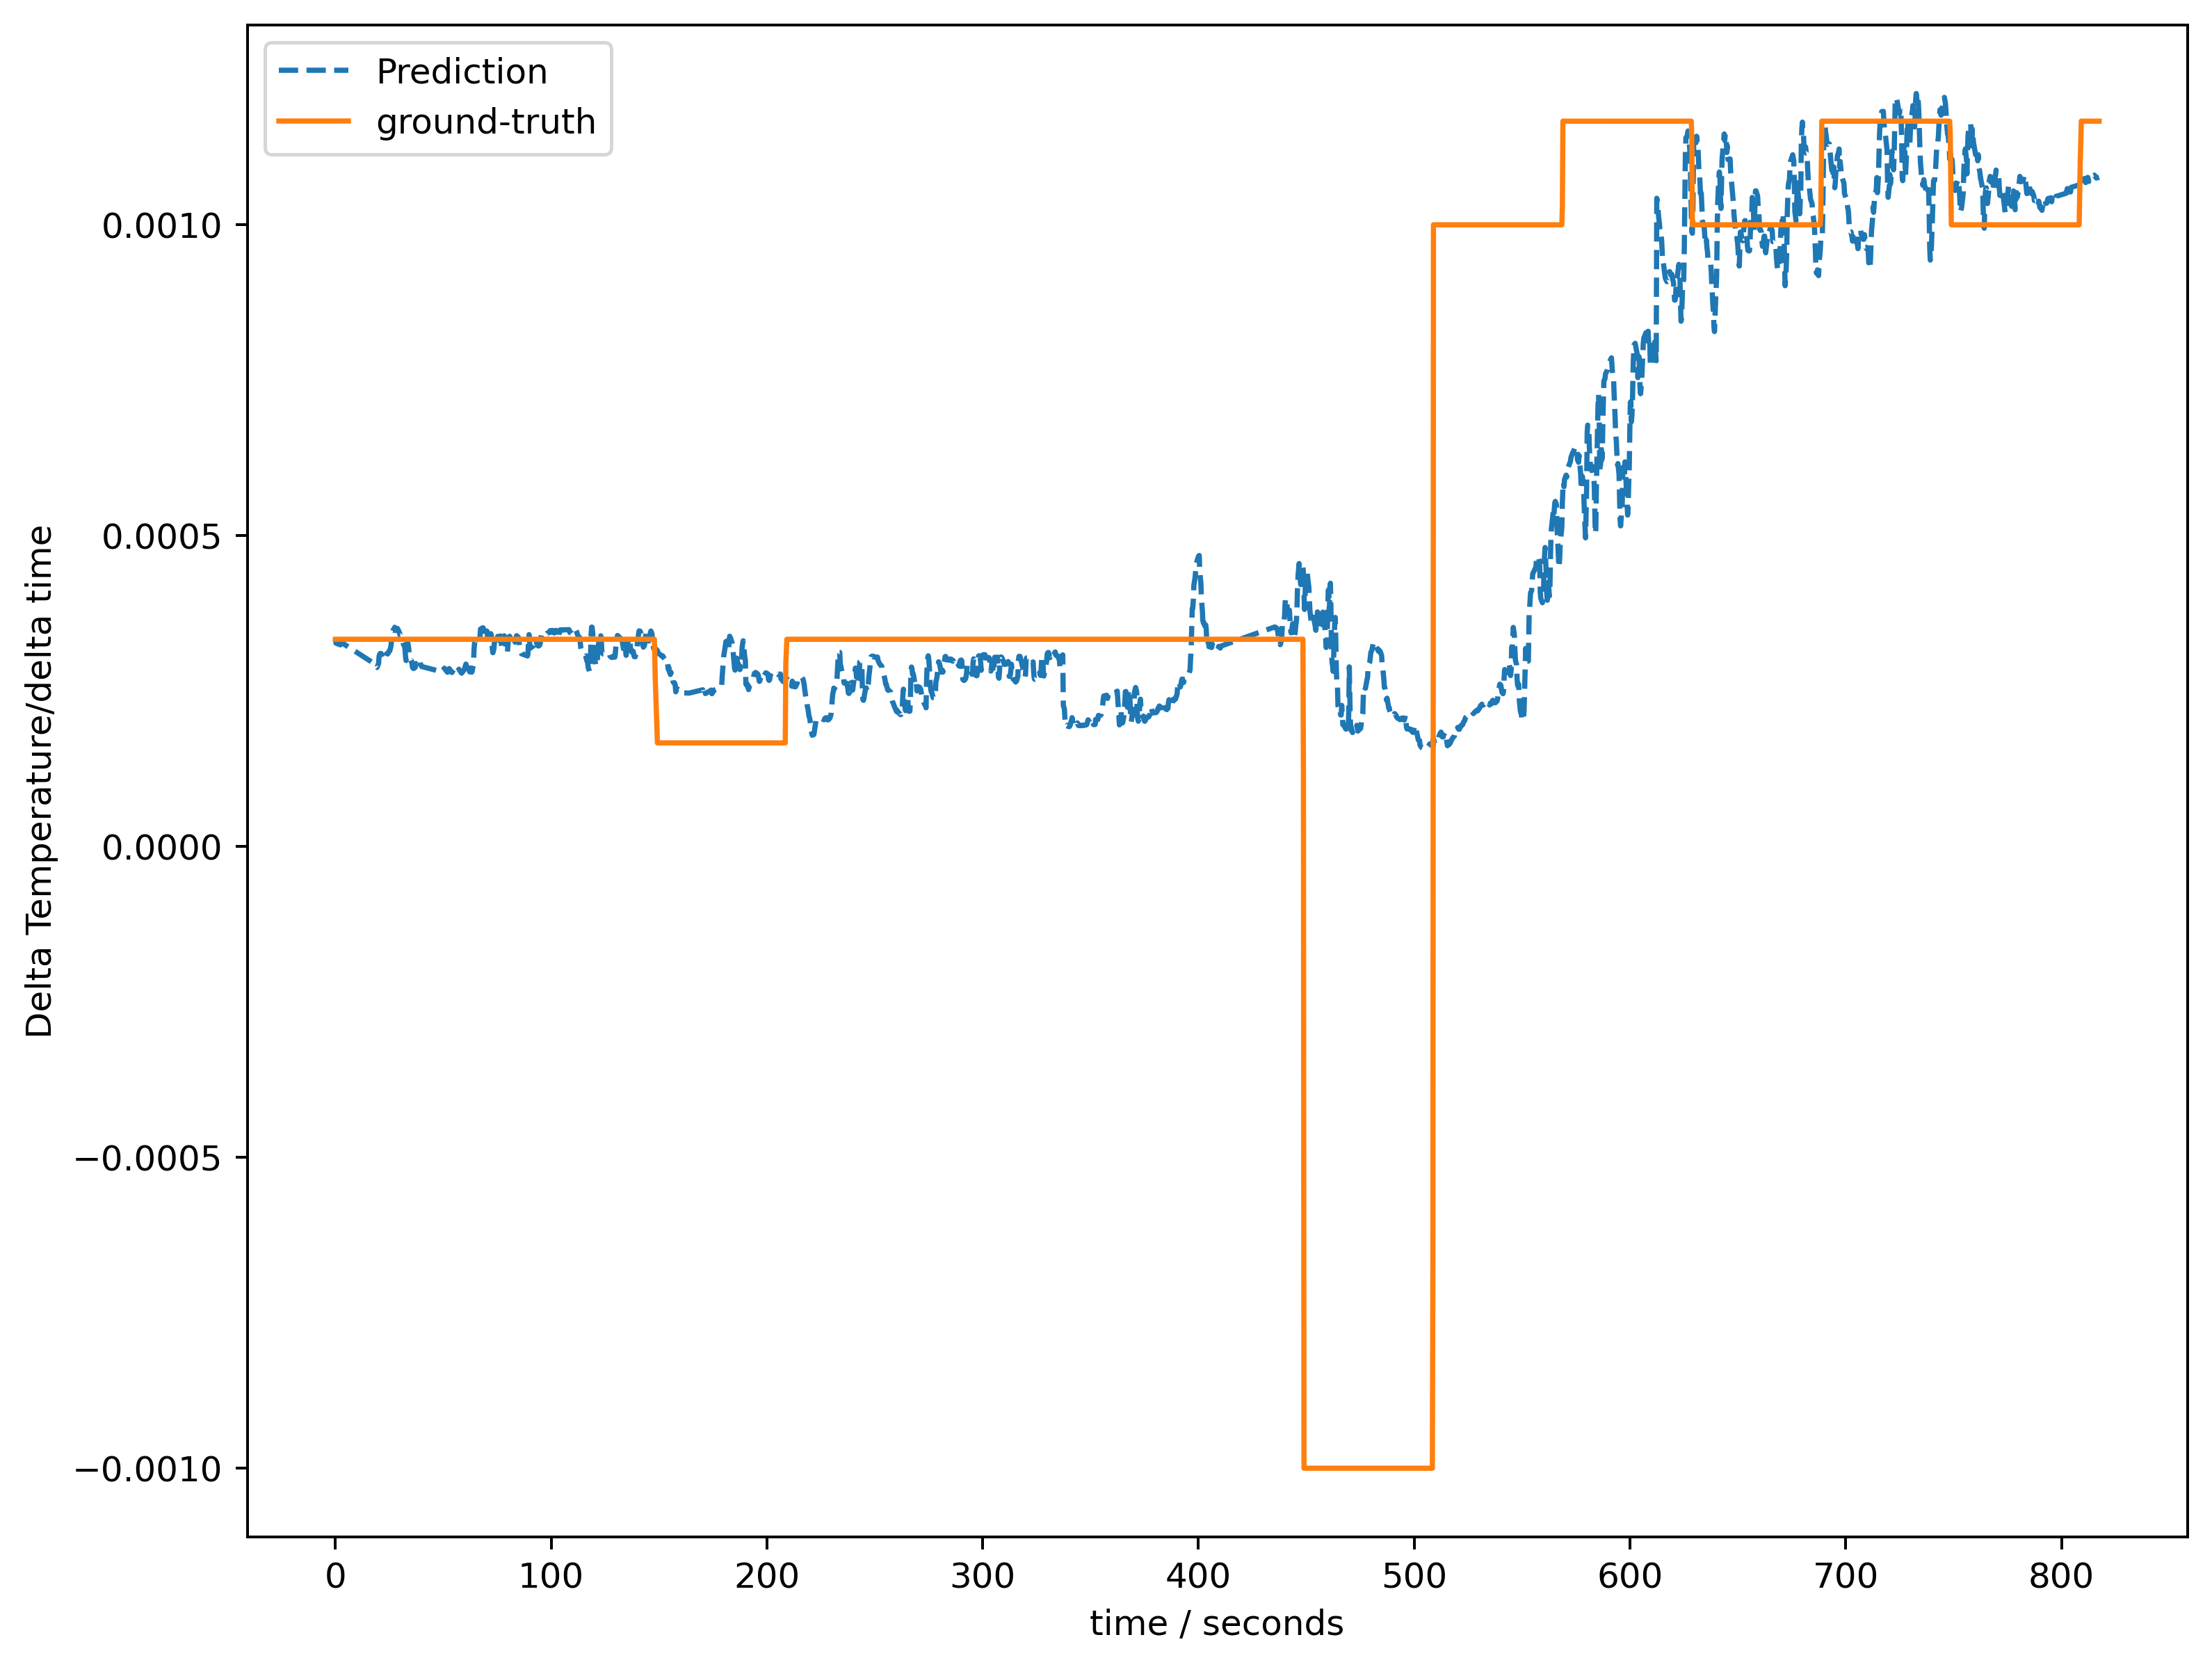

In [ ]:
figure(figsize=(10, 8), dpi= 360)

#time
t=ds.t

plt.plot(t,pred, '--')
plt.plot(t,df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('time / seconds')
plt.ylabel('Delta Temperature/delta time')
plt.show()

In [ ]:
# Import a slice of the datase (based on drive-id) for further analysis
ds = TeslaDatasetDiff(device = device, ID = 70)

(1059, 10)


MAE: 6.947628
MSE: 66.718346
Relative error (%): 28.096574544906616


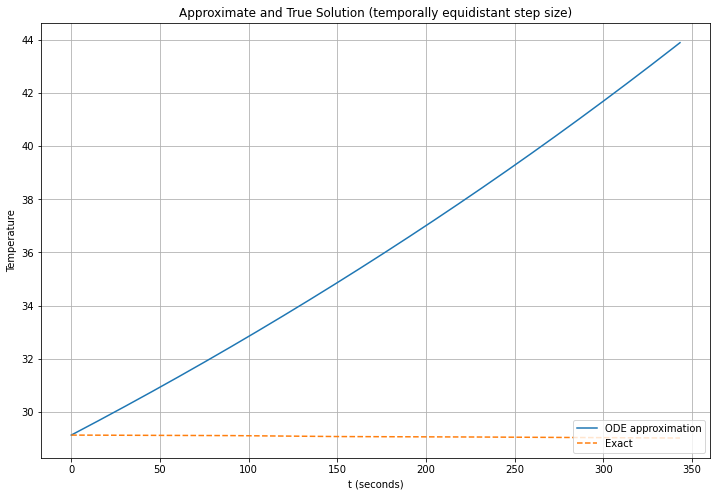

In [ ]:
#Forward Euler method with fixed initial conditions but with updated 
#Temperature from the prediction of the model at previous iteration
#with generated temporally equidistant time steps

# ground-truth time
t=ds.t
max_t = t.max()

# Ground-truth temperature
true_temp = ds.x[:,4].numpy()

# Predicted temperature using model prediction and forward euler method
pred_temp = np.zeros((ds.x.shape[0]))
pred_temp = true_temp.copy()

# Fixed initial conditions for all environmental conditions
input = ds.x[0].detach().clone()

# temporally equdistant time steps
tt = np.linspace(0,max_t,ds.x.shape[0])
step_size=tt[2]-tt[1]

#ODE
for i in range(0, ds.x.shape[0] - 1):
      input[4] = torch.tensor(pred_temp[i]).detach().clone()
      pred = model(input.to(device))
      pred = pred.detach().cpu().numpy()/normalize
      pred_temp[i + 1] = pred_temp[i] + pred*step_size


#MAE
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

#Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(tt, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate and True Solution (temporally equidistant step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()

MAE: 6.780814
MSE: 63.287106
Relative error (%): 27.36455500125885


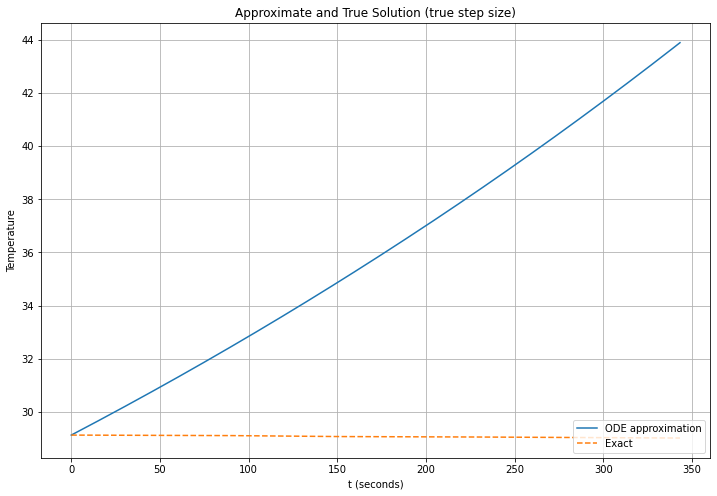

In [ ]:
#Forward Euler method with fixed initial conditions but with updated 
#Temperature from the prediction of the model at previous iteration
#with true step sizes

# ground-truth time
t=ds.t
max_t = t.max()
t=t.numpy()

# Ground-truth temperature
true_temp = ds.x[:,4].numpy()

# Predicted temperature using model prediction and forward euler method
#pred_temp = np.zeros((ds.x.shape[0]))
pred_temp[0] = true_temp[0].copy()

# Fixed initial conditions for all environmental conditions
input = ds.x[0].detach().clone()

# temporally equdistant time steps
tt = np.linspace(0,max_t,ds.x.shape[0])
step_size=tt[2]-tt[1]

# ODE
for i in range(0, ds.x.shape[0] - 1):
      #input = df_xx_tensor[0]
      input[4] = torch.tensor(pred_temp[i]).detach().clone()
      pred = model(input.to(device))
      pred = pred.detach().cpu().numpy()/normalize
      pred_temp[i + 1] = pred_temp[i] + pred*(t[i+1]-t[i])
      
#MAE 
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

# Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(t, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate and True Solution (true step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()


MAE: 6.790239915153049
MSE: 63.46434763904994
Relative error (%): 27.402846642082316


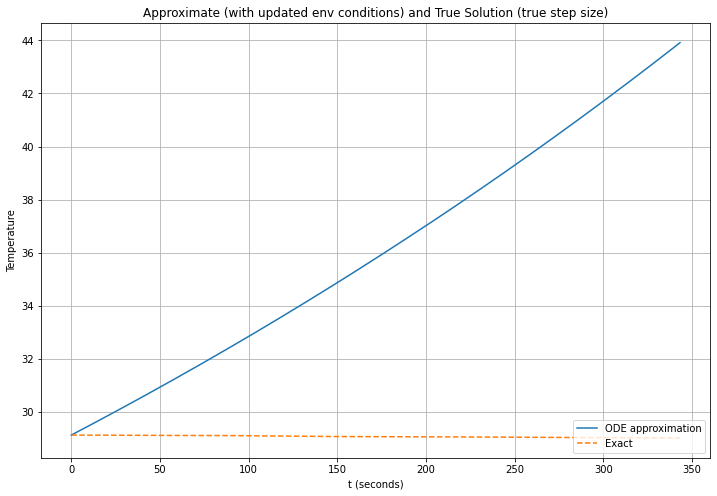

In [ ]:
#Forward Euler method with updated environmental conditions from the dataset at each iteration
#But with updated temperature from the prediction of the model at previous iteration
#with true step sizes

# ground-truth time
t=ds.t
max_t = t.max()
t=t.numpy()

# Ground-truth temperature
true_temp = ds.x[:,4].numpy()

# Predicted temperature using model prediction and forward euler method
pred_temp = np.zeros((ds.x.shape[0]))
pred_temp[0] = true_temp[0].copy()


for i in range(0, ds.x.shape[0] - 1):
      input = ds.x[i].detach().clone()
      input[4] = torch.tensor(pred_temp[i]).detach().clone()
      pred = model(input.to(device))
      pred = pred.detach().cpu().numpy()/normalize
      pred_temp[i + 1] = pred_temp[i] + pred*(t[i+1]-t[i])

#MAE 
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

# Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(t, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate (with updated env conditions) and True Solution (true step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()


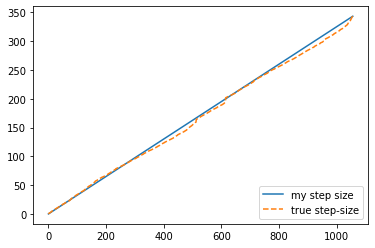

In [ ]:
plt.plot(tt, '-', label='my step size')
plt.plot(t, '--', label='true step-size')
plt.legend(loc='lower right')

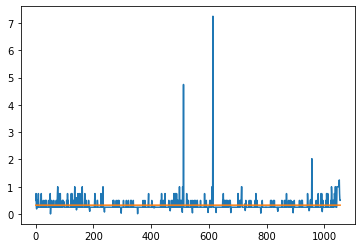

In [ ]:
plt.plot(np.diff(t.reshape(-1)))
plt.plot(np.diff(tt.reshape(-1)))

MAE: 0.011475666
MSE: 0.00024631582
Relative error (%): 0.05398547509685159


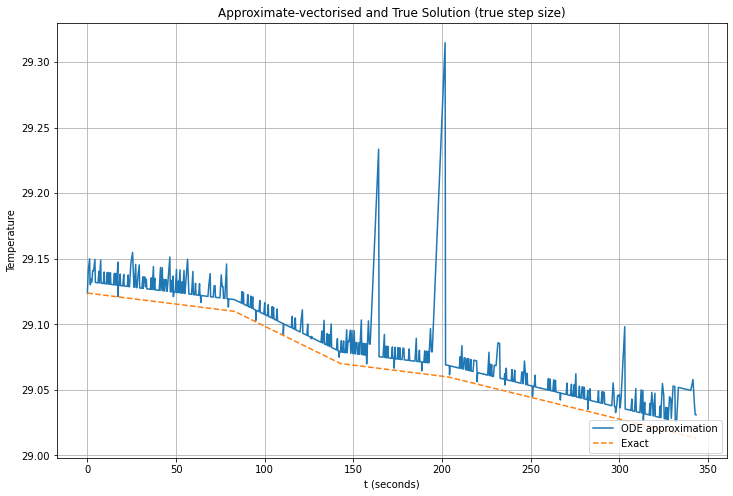

In [ ]:
# Checking if vectorised version of the loss works

true_temp = ds.x[:,4].numpy()
pred_temp = true_temp.copy()

prediction = model(ds.x.to(device)) 

deltaTemp = prediction.reshape(-1)*ds.dt.reshape(-1)/normalize

temp0 = pred_temp + deltaTemp.detach().cpu().numpy()
pred_temp[1:] = temp0[:-1]

#MAE
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

#Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(t, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate-vectorised and True Solution (true step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()



In [ ]:

model.load_state_dict(torch.load('model_' + str(normalize) + str(batch_size)+'.pt'))

<All keys matched successfully>